#### This notebook analyses mixed layer depth (MLD) diagnostics in the ACCESS-OM2 experiments.

In [93]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline
# plt.rcParams['figure.dpi'] = 200

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:39543 Dashboard: /proxy/33523/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [5]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

In [9]:
# Mixed layer depth: "mixed layer depth determined by density criteria"

yr_beg = '2400-01-16'

expt = '1deg_jra55_ryf_cont'
var = 'mld'
frequency = '1 monthly'
mld_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [10]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'mld'
frequency = '1 monthly'
mld_warmx1 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [11]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'mld'
frequency = '1 monthly'
mld_coolx1 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [8]:
# expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
# var = 'mld'
# frequency = '1 monthly'
# mld_warmx2 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [8]:
# expt = '1deg_jra55_ryf_RCPcool_humid_x2'
# var = 'mld'
# frequency = '1 monthly'
# mld_coolx2 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [12]:
mld_cont = mld_cont.load()
mld_warmx1 = mld_warmx1.load()
mld_coolx1 = mld_coolx1.load()
# mld_warmx2 = mld_warmx2.load()
#mld_coolx2 = mld_coolx2.load()

In [13]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (25, 12))

# year_index = 10

# plt.suptitle(f'Mixed layer depth anomalies at year {year_index}', fontsize=22)

# vmax = 200
# vmin = - vmax

# axs = ax[0]
# cool = ((mld_coolx1 - mld_cont).isel(year=year_index)).plot(ax=axs, vmin=vmin, vmax=vmax, add_colorbar=False, cmap = 'RdBu_r')
# axs.set_title('Cooling', fontsize=20)
# axs.set_ylabel('Latitude ($\degree$N)', fontsize=16)
# axs.set_xlabel('Longitude ($\degree$E)', fontsize=16)
# axs.tick_params(labelsize=14)

# axs = ax[1]
# warm = ((mld_warmx1 - mld_cont).isel(year=year_index)).plot(ax=axs, vmin=vmin, vmax=vmax, add_colorbar=False, cmap = 'RdBu_r')
# axs.set_title('Warming', fontsize=20)
# axs.set_ylabel('')
# axs.set_xlabel('Longitude ($\degree$E)', fontsize=16)
# axs.tick_params(labelsize=14)

# cb = plt.colorbar(cool, orientation='vertical', shrink = 0.9, aspect = 50, pad = 0.03)
# cb.set_label(label='MLD anomaly (m)', fontsize=18)
# #plt.savefig('MLD_year10.jpg')

In [78]:
def area_weighted_ave(tracer, expt):
    lat_lower = float(tracer['yt_ocean'][0]) # so that this function will work when we have hemipsherically-decomposed
    lat_upper = float(tracer['yt_ocean'][-1])
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean=slice(lat_lower, lat_upper)).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean

    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

def NH_decomp(array):
    return array.sel(yt_ocean = slice(0, None))

def SH_decomp(array):
    return array.sel(yt_ocean = slice(None, 0))

In [79]:
# Global means:

expt = '1deg_jra55_ryf_cont'
tracer = mld_cont
mld_cont_ave = area_weighted_ave(tracer, expt)
mld_cont_ave_SH = area_weighted_ave(SH_decomp(tracer), expt)
mld_cont_ave_NH = area_weighted_ave(NH_decomp(tracer), expt)

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
tracer = mld_warmx1
mld_warmx1_ave = area_weighted_ave(tracer, expt)
mld_warmx1_ave_SH = area_weighted_ave(SH_decomp(tracer), expt)
mld_warmx1_ave_NH = area_weighted_ave(NH_decomp(tracer), expt)

expt = '1deg_jra55_ryf_RCPcool_humid_x1'
tracer = mld_coolx1
mld_coolx1_ave = area_weighted_ave(tracer, expt)
mld_coolx1_ave_SH = area_weighted_ave(SH_decomp(tracer), expt)
mld_coolx1_ave_NH = area_weighted_ave(NH_decomp(tracer), expt)

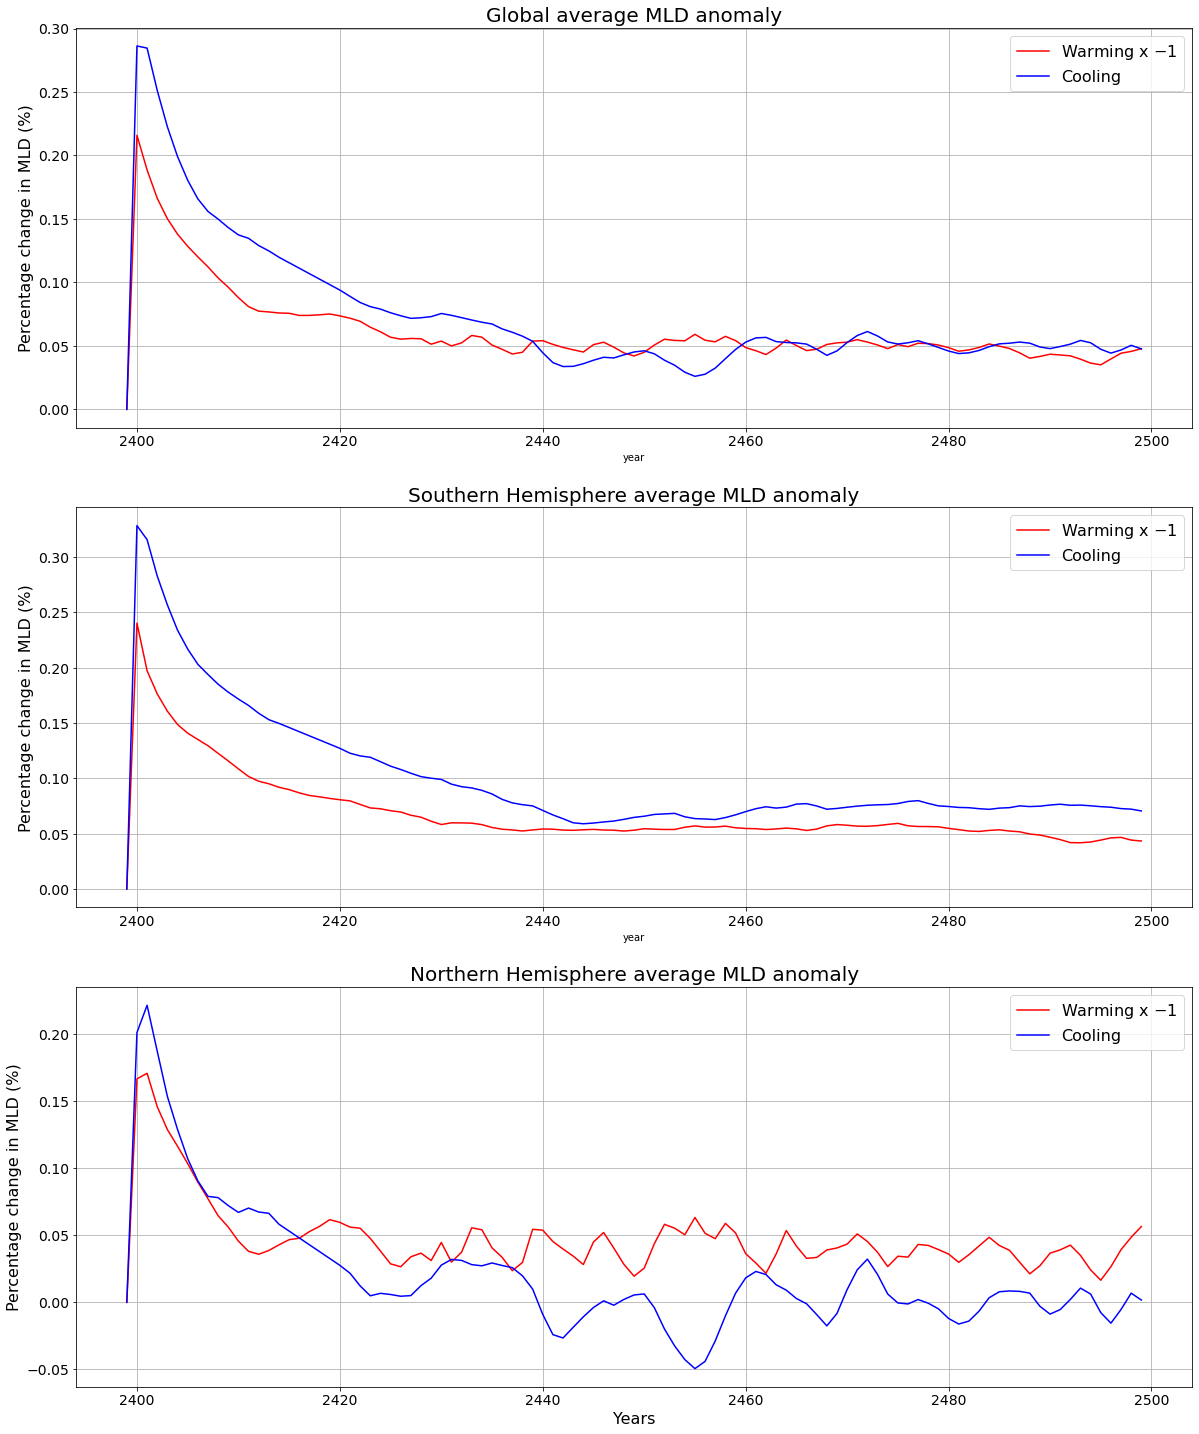

In [109]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize = (20,25))

def mld_plot(cont, cool, warm, title):
    zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
    mld_warm_anom = xr.concat([zero, (warm - cont) / cont], dim='year')
    mld_cool_anom = xr.concat([zero, (cool - cont) / cont], dim='year')
    (-1 * mld_warm_anom).plot(ax = ax, label='Warming x $-1$', color = 'r')
    mld_cool_anom.plot(ax = ax, label='Cooling', color = 'b')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('Percentage change in MLD (%)', fontsize=16)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=16)
    ax.grid()

ax = axs[0]
mld_plot(mld_cont_ave, mld_coolx1_ave, mld_warmx1_ave, 'Global average MLD anomaly')

ax = axs[1]
mld_plot(mld_cont_ave_SH, mld_coolx1_ave_SH, mld_warmx1_ave_SH, 'Southern Hemisphere average MLD anomaly')

ax = axs[2]
mld_plot(mld_cont_ave_NH, mld_coolx1_ave_NH, mld_warmx1_ave_NH, 'Northern Hemisphere average MLD anomaly')
ax.set_xlabel('Years', fontsize=16)

plt.savefig('step_mld_anoms.jpg', bbox_inches='tight')

### Sinusoidal simulations

In [14]:
expt = '1deg_jra55_ryf_sinusoid_x1_period2'
var = 'mld'
frequency = '1 yearly'
mld_period2 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [15]:
expt = '1deg_jra55_ryf_sinusoid_x1_period5'
var = 'mld'
frequency = '1 yearly'
mld_period5 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [16]:
expt = '1deg_jra55_ryf_sinusoid_x1_period10'
var = 'mld'
frequency = '1 yearly'
mld_period10 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [17]:
expt = '1deg_jra55_ryf_sinusoid_x1_period20'
var = 'mld'
frequency = '1 yearly'
mld_period20 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [18]:
mld_cont.load()
mld_period2.load()
mld_period5.load()
mld_period10.load()
mld_period20.load()

<xarray.DataArray 'mld' (year: 105, yt_ocean: 300, xt_ocean: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * year      (year) int64 2400 2401 2402 2403 2404 ... 2500 2501 2502 2503 2504

In [19]:
# Zonal means:

expt = '1deg_jra55_ryf_sinusoid_x1_period2'
tracer = mld_period2
mld_period2_zonal = true_zonal_mean(tracer, expt)

expt = '1deg_jra55_ryf_sinusoid_x1_period5'
tracer = mld_period5
mld_period5_zonal = true_zonal_mean(tracer, expt)

expt = '1deg_jra55_ryf_sinusoid_x1_period10'
tracer = mld_period10
mld_period10_zonal = true_zonal_mean(tracer, expt)

expt = '1deg_jra55_ryf_sinusoid_x1_period20'
tracer = mld_period20
mld_period20_zonal = true_zonal_mean(tracer, expt)

NameError: name 'true_zonal_mean' is not defined

In [ ]:
expt = '1deg_jra55_ryf_sinusoid_x1_period2'
dzt = cc.querying.getvar(expt, 'dzt', session)

In [68]:
# Naive zonal mean

mld_cont_zonal = mld_cont.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period2_zonal = mld_period2.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period5_zonal = mld_period5.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period10_zonal = mld_period10.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period20_zonal = mld_period20.mean(dim=('xt_ocean', 'yt_ocean'))

In [51]:
# # True zonal mean

# mld_period2_zonal = mld_period2_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))
# mld_period5_zonal = mld_period5_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))
# mld_period10_zonal = mld_period10_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))
# mld_period20_zonal = mld_period20_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))

<Figure size 1368x864 with 0 Axes>

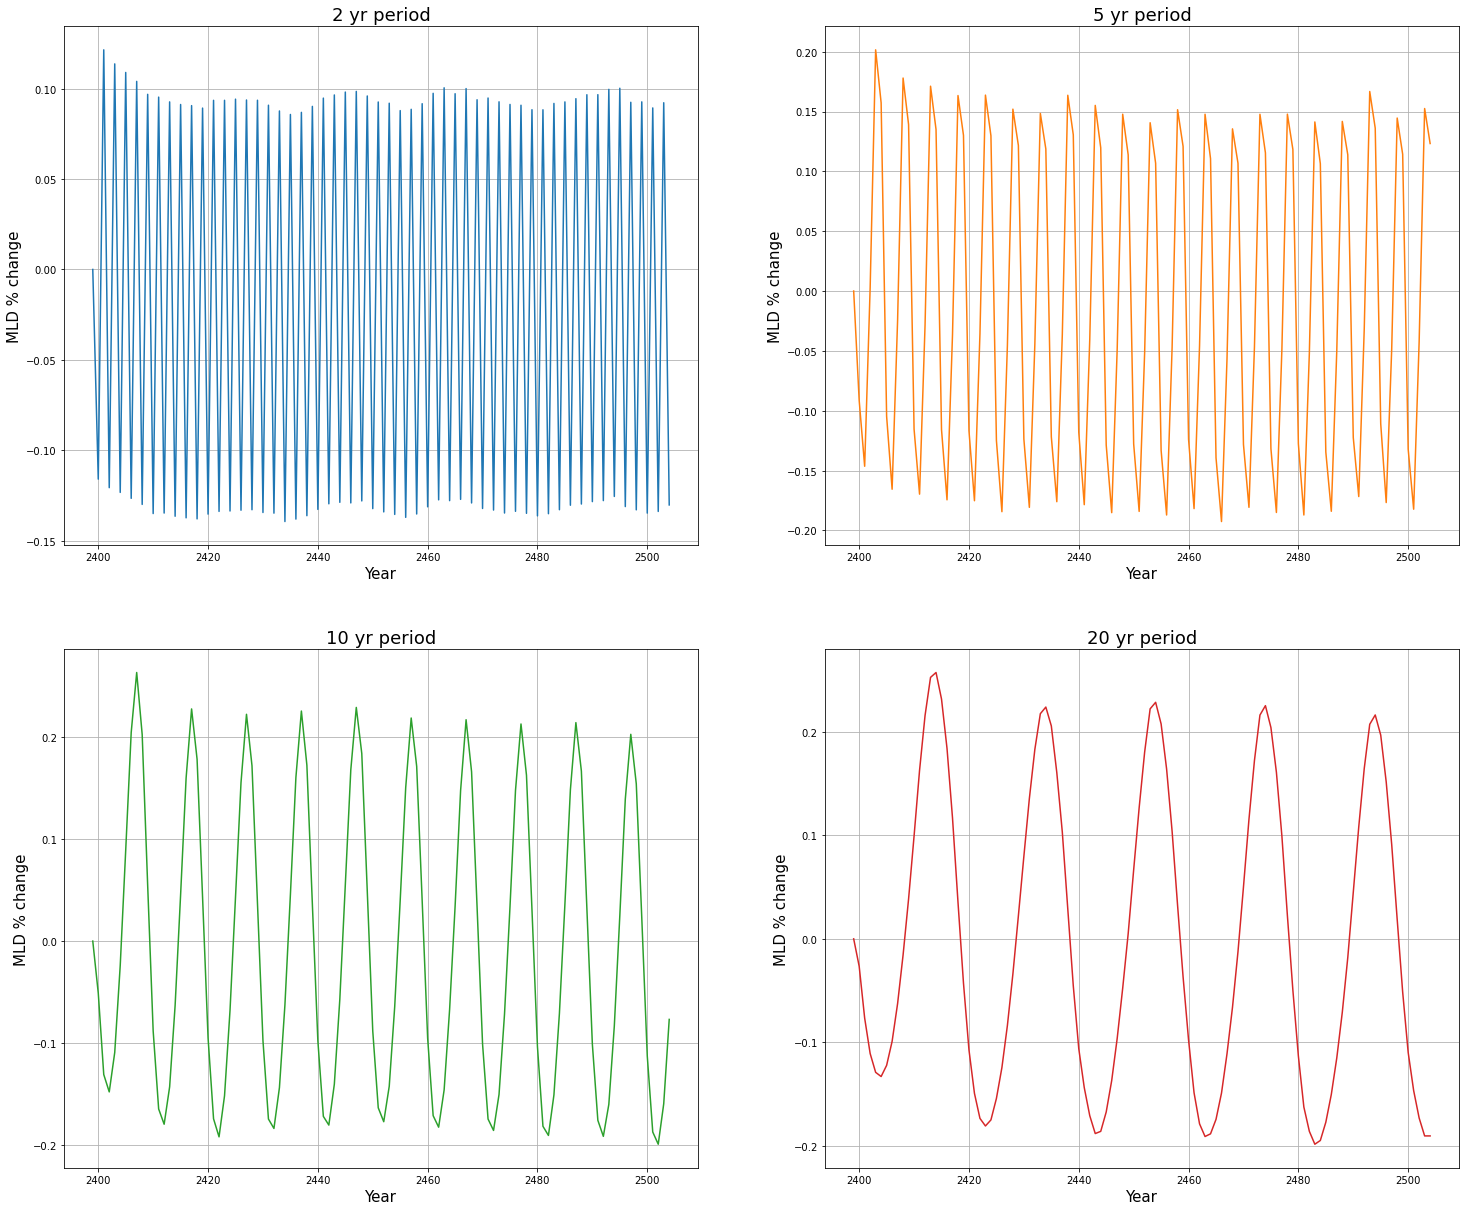

In [74]:
plt.figure(figsize = (19,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
mld_period2_anom = xr.concat([zero, (mld_period2_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')
mld_period5_anom = xr.concat([zero, (mld_period5_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')
mld_period10_anom = xr.concat([zero, (mld_period10_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')
mld_period20_anom = xr.concat([zero, (mld_period20_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')

fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (25, 21))

axs = ax[0, 0]
mld_period2_anom.plot(ax=axs, color = 'C0')
axs.set_title('2 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

axs = ax[0, 1]
mld_period5_anom.plot(ax=axs, color = 'C1')
axs.set_title('5 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

axs = ax[1, 0]
mld_period10_anom.plot(ax=axs, color = 'C2')
axs.set_title('10 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

axs = ax[1, 1]
mld_period20_anom.plot(ax=axs, color = 'C3')
axs.set_title('20 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

# plt.savefig('sinusoidal_mld_anoms.jpg')